Restaurant:
lr 1e-5
- Without Augmentation 85 %
- With Augmentation 88% (Dataset_Augmented/DeBERTa_Restaurant_Augmented) ReduceOnPlateau patience =3 factor = 0.1

Laptop:
lr = 2e-5
- Without Augmentation:  
- With Augmentation: 81.73% (Exponential Scheduler gamme = 0.9)

In [1]:
import torch
from tqdm import tqdm

In [2]:
import json
import pandas as pd

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Mon Jan 29 15:02:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
| 33%   34C    P5              63W / 350W |   2940MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load Datasets

In [5]:
def load_dataset(split={"train", "test", "dev"}, domain={"rest", "laptop"}):
    with open(f'asc/{domain}/{split}.json', 'r') as file:
        dataset = json.load(file)
    return list(dataset.values())

In [6]:
rest_train = load_dataset(split="train", domain="rest") + load_dataset(split="dev", domain = "rest")
rest_test = load_dataset(split="test", domain="rest")
laptop_train = load_dataset(split="train", domain="laptop") + load_dataset(split="dev", domain = "laptop")
laptop_test = load_dataset(split="test", domain="laptop")

## Preprocess

In [7]:
import re
import string

def clean_text(text):
    """
    Function to clean text data.
    :param text: The input string containing the text to be cleaned.
    :return: Cleaned text.
    """

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    return text

In [8]:
def clean_dataset(dataset):
    for element in tqdm(dataset, desc="Processing Text"):
        element['sentence'] = clean_text(element['sentence'])

In [9]:
clean_dataset(rest_train)
clean_dataset(laptop_train)
clean_dataset(rest_test)
clean_dataset(laptop_test)

Processing Text: 100%|████████████████████████████████████████████████████████████| 638/638 [00:00<00:00, 126159.35it/s]


In [10]:
def remove_duplicates(dataset):
    unique_data = []
    seen = set()
    
    for item in dataset:
        key = (item['sentence'], item['term'])
        if key not in seen:
            seen.add(key)
            unique_data.append(item)
    return unique_data

In [11]:
def check_duplicate(dataset):
    seen = set()
    for item in dataset:
        key = (item['sentence'], item['term'])
        if key in seen:
            print(key)
            return True
        seen.add(key)
    return False

In [12]:
rest_train = remove_duplicates(rest_train)
rest_test = remove_duplicates(rest_test)
laptop_train = remove_duplicates(laptop_train)
laptop_test = remove_duplicates(laptop_test)

In [13]:
print(check_duplicate(rest_test))

False


## Some DataAugmentation for imbalanced classes

In [14]:
from nlpaug.augmenter.word.synonym import SynonymAug
from nlpaug.augmenter.word.back_translation import BackTranslationAug
from nlpaug.augmenter.word.random import RandomWordAug
from nlpaug.augmenter.word.context_word_embs import ContextualWordEmbsAug
import random
def augment_dataset(dataset, negative_neutral_polarities = {'negative', 'neutral'}, probabilities = [0.5, 0.25, 0.25]):
    aug_syn = SynonymAug()
    aug_trans = BackTranslationAug(from_model_name='Helsinki-NLP/opus-mt-en-zh', to_model_name='Helsinki-NLP/opus-mt-zh-en')
    aug_word = RandomWordAug(action='swap')
    aug_context = ContextualWordEmbsAug(action='insert',model_path='roberta-base')
    
    augmented_data = []
    for item in tqdm(dataset):
        if item['polarity'] in negative_neutral_polarities:
            sentence = item['sentence']
            augmented_sentences = [sentence]
            n=random.choice([1,2])
            random_number = random.random()
            #if random_number <= probabilities[0]:
                #augmented_sentences += aug_word.augment(sentence)
            #elif random_number <= sum(probabilities[:2]):
                #augmented_sentences += aug_syn.augment(sentence, n=n)
            #elif random_number <= sum(probabilities[:3]):
                #augmented_sentences += aug_context.augment(sentence, n = n)
            if random_number <= sum(probabilities):
                try:
                    augmented_sentences += aug_trans.augment(sentence, n=n)
                except Exception as e:
                    print(f"Error in back-translation: {e}")
            for new_sentence in augmented_sentences:
                augmented_data.append({
                    'polarity': item['polarity'],
                    'term': item['term'],
                    'id': item['id'],
                    'sentence': new_sentence
                })
        else:
            augmented_data.append({
                    'polarity': item['polarity'],
                    'term': item['term'],
                    'id': item['id'],
                    'sentence': item['sentence']
                })
    print("Finished Augmentation")
    return augmented_data

In [15]:
rest_train_augmented = rest_train#augment_dataset(rest_train, negative_neutral_polarities={'neutral', 'negative'}, probabilities=[0, 0, 0, 1])

In [16]:
laptop_train_augmented = laptop_train#augment_dataset(laptop_train, negative_neutral_polarities={'neutral'}, probabilities=[0, 0, 0, 1])

In [17]:
import json
with open('datasets/rest_train_augmented.json', 'r') as file:
    rest_train_augmented = json.load(file)

In [18]:
pos = 0
neg = 0
neu = 0
for item in rest_train_augmented:
    polarity = item['polarity']
    if polarity == 'positive':
        pos += 1
    elif polarity == 'negative':
        neg += 1
    elif polarity == 'neutral':
        neu += 1
print(f"Positive : {pos}")
print(f"Negative : {neg}")
print(f"Neutral : {neu}")

print(f"Total: {len(rest_train_augmented)}")

Positive : 2144
Negative : 1988
Neutral : 1549
Total: 5681


## Add Aspects

In [19]:
rest_train_sentences = [item['term'] + ' [SEP] ' + item['sentence'] for item in rest_train_augmented]
laptop_train_sentences = [item['term'] + ' [SEP] ' + item['sentence'] for item in laptop_train_augmented]

rest_test_sentences = [item['term'] + ' [SEP] ' + item['sentence'] for item in rest_test]
laptop_test_sentences = [item['term'] + ' [SEP] ' + item['sentence'] for item in laptop_test]

In [20]:
#rest_train_sentences = [" ".join(item['sentence']) for item in rest_train]
rest_train_polarities = [item['polarity'] for item in rest_train_augmented]

#rest_test_sentences = [" ".join(item['sentence']) for item in rest_test]
rest_test_polarities = [item['polarity'] for item in rest_test]


#laptop_train_sentences = [" ".join(item['sentence']) for item in laptop_train]
laptop_train_polarities = [item['polarity'] for item in laptop_train_augmented]

#laptop_test_sentences = [" ".join(item['sentence']) for item in laptop_test]
laptop_test_polarities = [item['polarity'] for item in laptop_test]

In [21]:
import random
random_index = random.randint(0, len(rest_train_sentences))
random_sentence = rest_train_sentences[random_index]
random_polarity = rest_train_polarities[random_index]
print(random_sentence)
print(random_polarity)

selection of wine [SEP] great selection of wine and seafood
positive


In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
rest_y_train = label_encoder.fit_transform(rest_train_polarities)
rest_y_test = label_encoder.transform(rest_test_polarities)

laptop_y_train = label_encoder.fit_transform(laptop_train_polarities)
laptop_y_test = label_encoder.transform(laptop_test_polarities)

## Define Model (Deberta)

In [23]:
from transformers import DebertaTokenizer

sentence = "service [SEP] service was great"
# Load the DeBERTa tokenizer
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

tokenized_output = tokenizer.tokenize(sentence)

#encoded_input = tokenizer.encode(sentence, add_special_tokens=True)

print(tokenized_output)

['service', 'Ġ', '[SEP]', 'Ġservice', 'Ġwas', 'Ġgreat']


In [24]:
from transformers import DebertaV2Config, DebertaV2ForSequenceClassification, DebertaV2Tokenizer
from transformers import DebertaForSequenceClassification, DebertaTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

model_name = 'microsoft/deberta-base'
# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode_sentences(sentences, max_length=128):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sentence,                      # Sentence to encode
                            add_special_tokens=True,       # Add '[CLS]' and '[SEP]'
                            max_length=max_length,         # Pad & truncate all sentences
                            padding='max_length',          # Pad all sentences to max length
                            truncation=True,               # Explicitly truncate to max length
                            return_attention_mask=True,    # Construct attention masks
                            return_tensors='pt',           # Return pytorch tensors
                        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


# Encode the sentences (X_train and X_test)
rest_train_inputs, rest_train_masks = encode_sentences(rest_train_sentences)
rest_test_inputs, rest_test_masks = encode_sentences(rest_test_sentences)

laptop_train_inputs, laptop_train_masks = encode_sentences(laptop_train_sentences)
laptop_test_inputs, laptop_test_masks = encode_sentences(laptop_test_sentences)

In [25]:
print(len(rest_train_inputs))
print(len(rest_train_sentences))
print(len(rest_train_masks))

5681
5681
5681


In [26]:
rest_train_labels = torch.tensor(rest_y_train)
rest_test_labels = torch.tensor(rest_y_test)

laptop_train_labels = torch.tensor(laptop_y_train)
laptop_test_labels = torch.tensor(laptop_y_test)

In [27]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, inputs, masks, labels, original_sentences):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels
        self.original_sentences = original_sentences

    def __len__(self):
        return len(self.original_sentences)

    def __getitem__(self, idx):
        input = self.inputs[idx] 
        mask = self.masks[idx]
        label = self.labels[idx]
        original_sentence = self.original_sentences[idx]  # Storing the original sentence
        return input, mask, label, original_sentence

In [28]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16  # Adjust this according to your GPU capacity


# Create the DataLoader for our training set
rest_train_data = TensorDataset(rest_train_inputs, rest_train_masks, rest_train_labels)
rest_train_sampler = RandomSampler(rest_train_data)
rest_train_dataloader = DataLoader(rest_train_data, sampler=rest_train_sampler, batch_size=batch_size) 

# Create the DataLoader for our test set
rest_test_data = MyDataset(rest_test_inputs, rest_test_masks, rest_test_labels, rest_test_sentences)
rest_test_sampler = SequentialSampler(rest_test_data)
rest_test_dataloader = DataLoader(rest_test_data, sampler=rest_test_sampler, batch_size=batch_size)

# Create the DataLoader for our training set
laptop_train_data = TensorDataset(laptop_train_inputs, laptop_train_masks, laptop_train_labels)
laptop_train_sampler = RandomSampler(laptop_train_data)
laptop_train_dataloader = DataLoader(laptop_train_data, sampler=laptop_train_sampler, batch_size=batch_size) 

# Create the DataLoader for our test set
laptop_test_data = MyDataset(laptop_test_inputs, laptop_test_masks, laptop_test_labels, laptop_test_sentences)
laptop_test_sampler = SequentialSampler(laptop_test_data)
laptop_test_dataloader = DataLoader(laptop_test_data, sampler=laptop_test_sampler, batch_size=batch_size)

In [29]:
# Initializing a DeBERTa-v2 microsoft/deberta-v2-xlarge style configuration
#configuration = DebertaV2Config()
import torch.nn as nn
# Initializing a model (with random weights) from the microsoft/deberta-v2-xlarge style configuration
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3)
# Tell the model to run on GPU
model.to(device)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermed

In [43]:
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup, get_cosine_schedule_with_warmup
import torch.optim as optim
import torch
# Implement the training loop
epochs = 15

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps = 1e-8)

# Total number of training steps
total_steps = len(rest_train_dataloader) * epochs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience =3, factor = 0.1)
# Create the learning rate scheduler.
#scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=2 * len(train_dataloader))

AttributeError: module 'torch.optim.lr_scheduler' has no attribute 'ReduceOnPlateau'

In [45]:
def train(model, epochs, train_dataloader, optimizer):
    training_loss = []
    training_progress = []
    for epoch in range(0, epochs):
        # Training step
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_dataloader, desc="Epoch {:1d}".format(epoch+1), leave=False, disable=False)
        for batch in progress_bar:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Clear previously calculated gradients
            model.zero_grad()        
            # Perform a forward pass
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            training_progress.append(loss.item())

            # Perform a backward pass
            loss.backward()

            # Update parameters and take a step using the computed gradient
            optimizer.step()
            # Update the progress bar
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Calculate the average loss over the training data.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        print(f"  Average training loss: {avg_train_loss:.2f}")
        training_loss.append(avg_train_loss)

In [46]:
def evaluate(model, test_dataloader, scheduler):
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
    import numpy as np
    validation_acc = []
    validation_prec = []
    validation_f1 = []
    validation_recall = []
    validation_loss = []

    
    model.eval()

    # Initialize variables to gather predictions and true labels
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        total_eval_loss = 0
        for batch in tqdm(test_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            #token_type_ids = None
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

            loss = outputs.loss
            total_eval_loss += loss.item()

            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Store predictions and true labels
            all_predictions.extend(np.argmax(logits, axis=1).flatten())
            all_true_labels.extend(label_ids.flatten())
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_true_labels, all_predictions)
    avg_test_loss = total_eval_loss / len(test_dataloader)
    
    scheduler.step(accuracy)
    
    validation_acc.append(accuracy)
    validation_prec.append(precision)
    validation_f1.append(f1_score)
    validation_recall.append(recall)
    validation_loss.append(avg_test_loss)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1_score:.4f}')
    return accuracy

In [47]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def objective(trial):
    LR = trial.suggest_float('lr', 2e-6, 2e-4)
    num_epochs = trial.suggest_int('num_epochs', 5, 15)
    
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3)
    # Tell the model to run on GPU
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, eps = 1e-8) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience =3, factor = 0.1)
    
    train(model, num_epochs, rest_train_dataloader, optimizer)
    
    acc = evaluate(model, scheduler= scheduler, test_dataloader=rest_test_dataloader)
    return acc

In [48]:
import optuna

In [49]:
#Create Study and Optimize Parameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, timeout=7200)

[I 2024-01-29 15:56:29,612] A new study created in memory with name: no-name-49420337-f5ca-4a64-9c4d-2a6c31b296de
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.10


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 26.97it/s]
/home/user/welzs0/anaconda3/envs/CudaLab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-01-29 16:06:33,568] Trial 0 finished with value: 0.649059982094897 and parameters: {'lr': 5.982447760378066e-05, 'num_epochs': 13}. Best is trial 0 with value: 0.649059982094897.


Accuracy: 0.6491
Precision: 0.4213
Recall: 0.6491
F1-Score: 0.5109


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 0.87


  Average training loss: 0.42


  Average training loss: 0.23


  Average training loss: 0.12


  Average training loss: 0.09


  Average training loss: 0.06


  Average training loss: 0.06


  Average training loss: 0.03


  Average training loss: 0.04


  Average training loss: 0.03


  Average training loss: 0.03


  Average training loss: 0.02


  Average training loss: 0.04


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 26.97it/s]
[I 2024-01-29 16:16:39,103] Trial 1 finished with value: 0.8495971351835273 and parameters: {'lr': 2.1547226208157202e-05, 'num_epochs': 13}. Best is trial 1 with value: 0.8495971351835273.


Accuracy: 0.8496
Precision: 0.8405
Recall: 0.8496
F1-Score: 0.8423


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.02it/s]
/home/user/welzs0/anaconda3/envs/CudaLab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-01-29 16:20:34,139] Trial 2 finished with value: 0.649059982094897 and parameters: {'lr': 9.85753489182704e-05, 'num_epochs': 5}. Best is trial 1 with value: 0.8495971351835273.


Accuracy: 0.6491
Precision: 0.4213
Recall: 0.6491
F1-Score: 0.5109


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.09


  Average training loss: 1.06


  Average training loss: 1.06


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.01it/s]
/home/user/welzs0/anaconda3/envs/CudaLab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-01-29 16:25:15,208] Trial 3 finished with value: 0.649059982094897 and parameters: {'lr': 4.946444661921309e-05, 'num_epochs': 6}. Best is trial 1 with value: 0.8495971351835273.


Accuracy: 0.6491
Precision: 0.4213
Recall: 0.6491
F1-Score: 0.5109


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.10


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.04it/s]
/home/user/welzs0/anaconda3/envs/CudaLab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-01-29 16:35:20,558] Trial 4 finished with value: 0.649059982094897 and parameters: {'lr': 0.00019131950983481498, 'num_epochs': 13}. Best is trial 1 with value: 0.8495971351835273.


Accuracy: 0.6491
Precision: 0.4213
Recall: 0.6491
F1-Score: 0.5109


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 0.66


  Average training loss: 0.34


  Average training loss: 0.17


  Average training loss: 0.13


  Average training loss: 0.07


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 26.98it/s]
[I 2024-01-29 16:39:15,283] Trial 5 finished with value: 0.8433303491495077 and parameters: {'lr': 3.479167321966627e-05, 'num_epochs': 5}. Best is trial 1 with value: 0.8495971351835273.


Accuracy: 0.8433
Precision: 0.8402
Recall: 0.8433
F1-Score: 0.8398


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.06it/s]
/home/user/welzs0/anaconda3/envs/CudaLab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-01-29 16:45:28,751] Trial 6 finished with value: 0.649059982094897 and parameters: {'lr': 4.9785219821521424e-05, 'num_epochs': 8}. Best is trial 1 with value: 0.8495971351835273.


Accuracy: 0.6491
Precision: 0.4213
Recall: 0.6491
F1-Score: 0.5109


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.10


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 26.98it/s]
/home/user/welzs0/anaconda3/envs/CudaLab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-01-29 16:54:48,588] Trial 7 finished with value: 0.649059982094897 and parameters: {'lr': 0.00011416169692075062, 'num_epochs': 12}. Best is trial 1 with value: 0.8495971351835273.


Accuracy: 0.6491
Precision: 0.4213
Recall: 0.6491
F1-Score: 0.5109


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.06it/s]
/home/user/welzs0/anaconda3/envs/CudaLab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-01-29 17:04:08,027] Trial 8 finished with value: 0.17547000895255147 and parameters: {'lr': 0.00014433401570259136, 'num_epochs': 12}. Best is trial 1 with value: 0.8495971351835273.


Accuracy: 0.1755
Precision: 0.0308
Recall: 0.1755
F1-Score: 0.0524


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


  Average training loss: 1.09


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.09it/s]
/home/user/welzs0/anaconda3/envs/CudaLab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-01-29 17:14:59,616] Trial 9 finished with value: 0.649059982094897 and parameters: {'lr': 0.0001928163243436889, 'num_epochs': 14}. Best is trial 1 with value: 0.8495971351835273.


Accuracy: 0.6491
Precision: 0.4213
Recall: 0.6491
F1-Score: 0.5109


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 0.81


  Average training loss: 0.42


  Average training loss: 0.25


  Average training loss: 0.14


  Average training loss: 0.09


  Average training loss: 0.06


  Average training loss: 0.05


  Average training loss: 0.04


  Average training loss: 0.04


  Average training loss: 0.03


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.00it/s]
[I 2024-01-29 17:22:45,753] Trial 10 finished with value: 0.8639212175470009 and parameters: {'lr': 1.5084992337052115e-05, 'num_epochs': 10}. Best is trial 10 with value: 0.8639212175470009.


Accuracy: 0.8639
Precision: 0.8634
Recall: 0.8639
F1-Score: 0.8477


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 0.82


  Average training loss: 0.44


  Average training loss: 0.28


  Average training loss: 0.19


  Average training loss: 0.11


  Average training loss: 0.07


  Average training loss: 0.06


  Average training loss: 0.04


  Average training loss: 0.04


  Average training loss: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 26.99it/s]
[I 2024-01-29 17:30:32,362] Trial 11 finished with value: 0.8675022381378693 and parameters: {'lr': 1.0953308546770373e-05, 'num_epochs': 10}. Best is trial 11 with value: 0.8675022381378693.


Accuracy: 0.8675
Precision: 0.8607
Recall: 0.8675
F1-Score: 0.8621


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.05


  Average training loss: 0.59


  Average training loss: 0.34


  Average training loss: 0.21


  Average training loss: 0.13


  Average training loss: 0.08


  Average training loss: 0.06


  Average training loss: 0.05


  Average training loss: 0.04


  Average training loss: 0.03


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 26.97it/s]
[I 2024-01-29 17:38:18,584] Trial 12 finished with value: 0.8639212175470009 and parameters: {'lr': 8.35935077219885e-06, 'num_epochs': 10}. Best is trial 11 with value: 0.8675022381378693.


Accuracy: 0.8639
Precision: 0.8620
Recall: 0.8639
F1-Score: 0.8535


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 1.04


  Average training loss: 0.56


  Average training loss: 0.32


  Average training loss: 0.21


  Average training loss: 0.13


  Average training loss: 0.08


  Average training loss: 0.08


  Average training loss: 0.05


  Average training loss: 0.04


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.00it/s]
[I 2024-01-29 17:45:18,484] Trial 13 finished with value: 0.8630259623992838 and parameters: {'lr': 7.325824573759959e-06, 'num_epochs': 9}. Best is trial 11 with value: 0.8675022381378693.


Accuracy: 0.8630
Precision: 0.8574
Recall: 0.8630
F1-Score: 0.8587


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Average training loss: 0.74


  Average training loss: 0.43


  Average training loss: 0.26


  Average training loss: 0.16


  Average training loss: 0.10


  Average training loss: 0.08


  Average training loss: 0.05


  Average training loss: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.05it/s]
[I 2024-01-29 17:51:32,450] Trial 14 finished with value: 0.8585496866606983 and parameters: {'lr': 1.1082904713202193e-05, 'num_epochs': 8}. Best is trial 11 with value: 0.8675022381378693.


Accuracy: 0.8585
Precision: 0.8532
Recall: 0.8585
F1-Score: 0.8539


In [69]:
import pickle

# Save the study to a file
with open("saved_study_restaurant.pkl", "wb") as f:
    pickle.dump(study, f)

# Load the study from a file
#with open("saved_study.pkl", "rb") as f:
    #loaded_study = pickle.load(f)

In [67]:
initial_combination = {'lr': [2e-5], 'num_epochs': [15], 'accuracy': [0.885]}
optunas_trials = {'lr': [], 'num_epochs': [], 'accuracy': []}

for trial in study.trials:
    optunas_trials['accuracy'].append(trial.value)
    for key, value in trial.params.items():
        optunas_trials[key].append(value)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


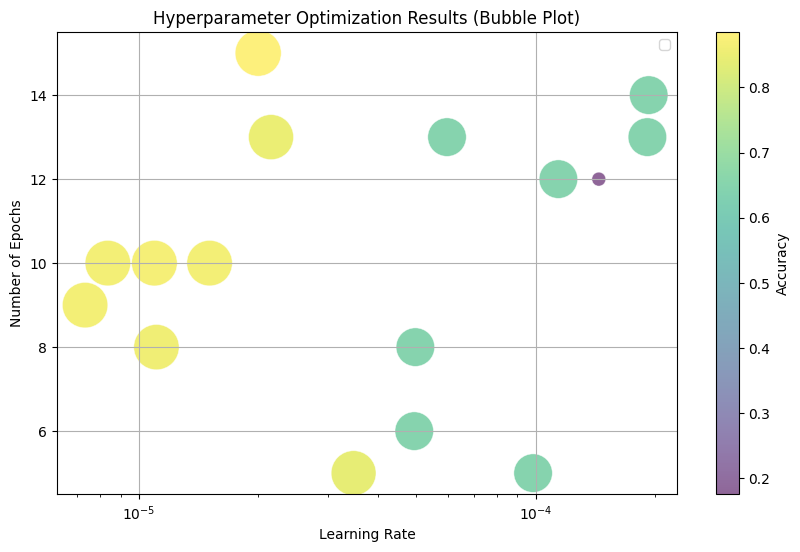

In [68]:
import numpy as np
import matplotlib.pyplot as plt

learning_rates = optunas_trials['lr'] + initial_combination['lr']
num_epochs = optunas_trials['num_epochs'] + initial_combination['num_epochs']
accuracies = optunas_trials['accuracy'] + initial_combination['accuracy']

# Assuming learning_rates, num_epochs, and accuracies are your data lists
LR = np.array(learning_rates)
NE = np.array(num_epochs)
Acc = np.array(accuracies)

# Normalize accuracies for bubble sizes
# The size can be adjusted to make the plot clearer
bubble_sizes = (Acc - Acc.min()) / (Acc.max() - Acc.min()) * 1000 + 100  # +100 to avoid size 0

plt.figure(figsize=(10, 6))

# Create the bubble plot
scatter = plt.scatter(LR, NE, s=bubble_sizes, c=Acc, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)

# Adding a color bar to show the accuracy values
cbar = plt.colorbar(scatter)
cbar.set_label('Accuracy')

plt.xscale('log')  # Using a log scale for learning rates due to wide range
plt.xlabel('Learning Rate')
plt.ylabel('Number of Epochs')
plt.title('Hyperparameter Optimization Results (Bubble Plot)')

plt.legend()
plt.grid(True)
plt.show()



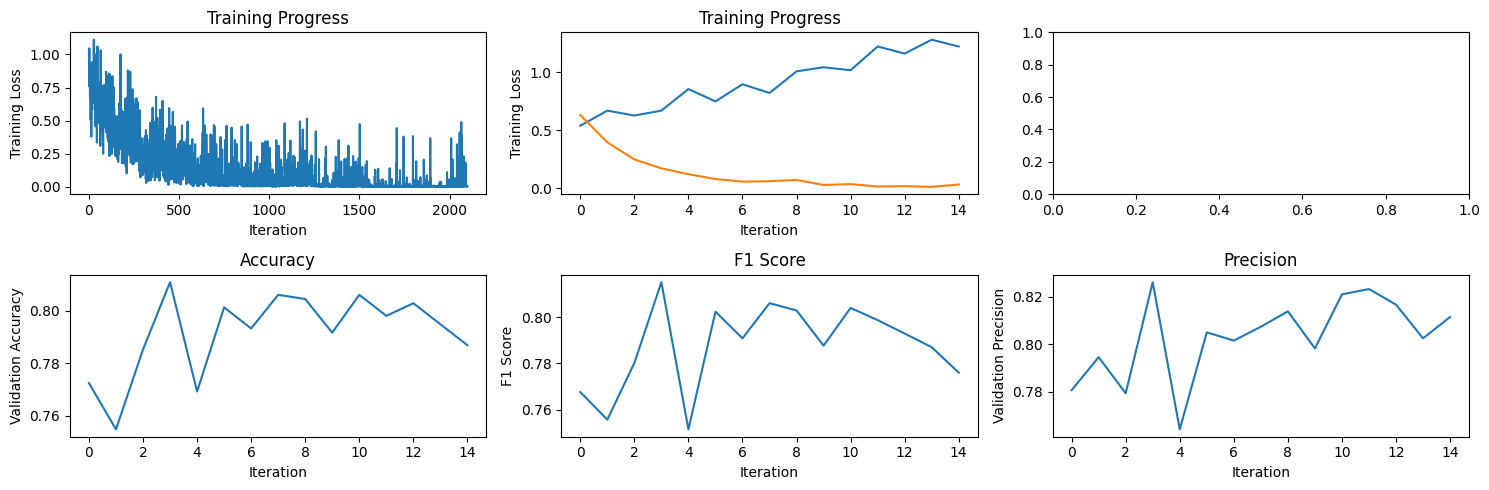

In [32]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(15,5))

axs[0, 0].plot(training_progress)
axs[0, 0].set_title("Training Progress")
axs[0, 0].set_xlabel("Iteration")
axs[0, 0].set_ylabel("Training Loss")

axs[0, 1].plot(validation_loss)
axs[0, 1].plot(training_loss)
axs[0, 1].set_title("Training Progress")
axs[0, 1].set_xlabel("Iteration")
axs[0, 1].set_ylabel("Training Loss")

axs[1, 1].plot(validation_f1)
axs[1, 1].set_title("F1 Score")
axs[1, 1].set_xlabel("Iteration")
axs[1, 1].set_ylabel("F1 Score")

axs[1, 0].plot(validation_acc)
axs[1, 0].set_title("Accuracy")
axs[1, 0].set_xlabel("Iteration")
axs[1, 0].set_ylabel("Validation Accuracy")

axs[1, 2].plot(validation_prec)
axs[1, 2].set_title("Precision")
axs[1, 2].set_xlabel("Iteration")
axs[1, 2].set_ylabel("Validation Precision")


plt.tight_layout()
plt.show()

## Evaluation Restaurant

In [42]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
model_name = 'microsoft/deberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3)
#Load best Model
model = model.to(device)
model.load_state_dict(torch.load('model_checkpoints/DeBERTa_Restaurant_augmented.bin'))

model.eval()
# Initialize variables to gather predictions and true labels
all_predictions = []
all_true_labels = []

misclassified_sentences = []
correctlyclassified_sentences = []

with torch.no_grad():
    total_eval_loss = 0
    for batch in tqdm(rest_test_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_original_sentence = batch[3]
        #token_type_ids = None
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        predictions = np.argmax(logits, axis=1)
        for sentence, prediction, actual_label in zip(b_original_sentence, predictions, label_ids):
            if prediction != actual_label and actual_label == 1:
                misclassified_sentences.append((sentence, prediction, actual_label))
            elif prediction == actual_label:
                correctlyclassified_sentences.append((sentence, prediction, actual_label))
        
        # Store predictions and true labels
        all_predictions.extend(predictions.flatten())
        all_true_labels.extend(label_ids.flatten())
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_true_labels, all_predictions)
avg_test_loss = total_eval_loss / len(rest_test_dataloader)

conf_matrix_rest = confusion_matrix(all_true_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1_score:.4f}')

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:07<00:00,  8.83it/s]

Accuracy: 0.8854
Precision: 0.8834
Recall: 0.8854
F1-Score: 0.8795


In [29]:

for sentence, prediction, label in misclassified_sentences[:40]:
    print(f"{sentence}")
    print(f"Prediction {label_encoder.classes_[prediction]} | Actual Label {label_encoder.classes_[label]}\n")

sauce [SEP] perfectly al dente pasta not drowned in sauce generous portions
Prediction negative | Actual Label neutral

dessert pizza [SEP] while theres a decent menu it shouldnt take ten minutes to get your drinks and for a dessert pizza
Prediction positive | Actual Label neutral

served [SEP] they are served on focacchia bread and are to die for
Prediction negative | Actual Label neutral

waitress [SEP] when she complained the waitress said sorry
Prediction negative | Actual Label neutral

french dish [SEP] good place to hang out during the day after shopping or to grab a simple soup or classic french dish over a glass of wine
Prediction positive | Actual Label neutral

dance floor [SEP] we were seated promptly in close proximity to the dance floor
Prediction positive | Actual Label neutral

beers [SEP] great beer selection too something like beers
Prediction positive | Actual Label neutral

Focacchia bread [SEP] they are served on focacchia bread and are to die for
Prediction positi

In [30]:
for sentence, prediction, label in correctlyclassified_sentences[:20]:
    print(f"{sentence}")
    print(f"Prediction {label_encoder.classes_[prediction]} | Actual Label {label_encoder.classes_[label]}\n")

calamari [SEP] for an appetizer their calamari is a winner
Prediction positive | Actual Label positive

service [SEP] the service is excellent and always informative without an air
Prediction positive | Actual Label positive

blue bar area [SEP] dug the blue bar area too
Prediction positive | Actual Label positive

back patio [SEP] have a mojito and sit in the back patio
Prediction positive | Actual Label positive

salmon dishes [SEP] i recommend any of their salmon dishes
Prediction positive | Actual Label positive

slices [SEP] finally let into the store at a time to buy expensive slices from a harried staff
Prediction negative | Actual Label negative

staff [SEP] finally let into the store at a time to buy expensive slices from a harried staff
Prediction negative | Actual Label negative

food [SEP] i thought the food isnt cheap at all compared to chinatown
Prediction negative | Actual Label negative

service [SEP] the service however is a peg or two below the quality of food horribl

## Evaluation Laptop

In [43]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
model_name = 'microsoft/deberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3)
#Load best Model
model = model.to(device)
model.load_state_dict(torch.load('model_checkpoints/DeBERTa_Laptop_augmented.bin'))

model.eval()
# Initialize variables to gather predictions and true labels
all_predictions = []
all_true_labels = []

with torch.no_grad():
    total_eval_loss = 0
    for batch in tqdm(laptop_test_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        #token_type_ids = None
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        all_predictions.extend(np.argmax(logits, axis=1).flatten())
        all_true_labels.extend(label_ids.flatten())
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_true_labels, all_predictions)
avg_test_loss = total_eval_loss / len(laptop_test_dataloader)

conf_matrix_laptop = confusion_matrix(all_true_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1_score:.4f}')

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 23.48it/s]

Accuracy: 0.8173
Precision: 0.8221
Recall: 0.8173
F1-Score: 0.8171


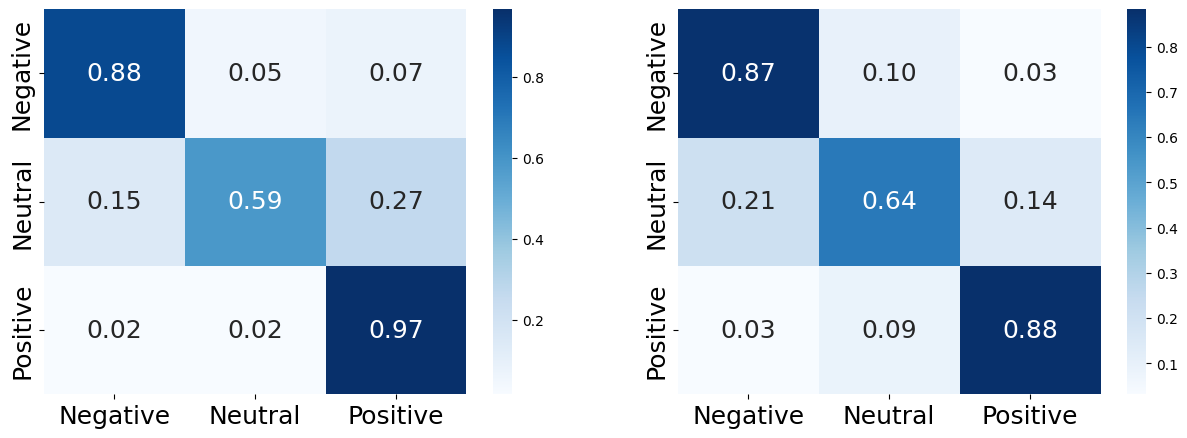

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix_rest = conf_matrix_rest.astype('float') / conf_matrix_rest.sum(axis=1)[:, np.newaxis]
conf_matrix_laptop = conf_matrix_laptop.astype('float') / conf_matrix_laptop.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(15,5))

annot_kws = {"size": 18}
labelsize = 18

sns.heatmap(conf_matrix_rest, annot=True, ax=axs[0], xticklabels = ["Negative", "Neutral", "Positive"], yticklabels = ["Negative", "Neutral", "Positive"]
           , fmt='.2f', cmap='Blues', annot_kws=annot_kws)
sns.heatmap(conf_matrix_laptop, annot=True, ax=axs[1], xticklabels = ["Negative", "Neutral", "Positive"], yticklabels = ["Negative", "Neutral", "Positive"]
           , fmt='.2f', cmap='Blues', annot_kws=annot_kws)


axs[0].tick_params(axis='both', which='major', labelsize=labelsize)
axs[1].tick_params(axis='both', which='major', labelsize=labelsize)


axs[0].spines['top'].set_visible=(True)
axs[0].spines['right'].set_visible=(True)



axs[1].spines['top'].set_visible=(True)
axs[1].spines['right'].set_visible=(True)
plt.savefig('Confusion_Matrix.png', dpi=300, transparent=True)
plt.show()

In [45]:
conf_matrix = conf_matrix_rest
# Negative
TP = conf_matrix[0,0]
FP = sum(conf_matrix[:, 0]) - TP
FN = sum(conf_matrix[0, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Negative--------------------")
print(f"Precision Negative: {precision}")
print(f"Recall Negative: {recall}")
print(f"F1 Score Negative: {f1}")

# Neutral
TP = conf_matrix[1,1]
FP = sum(conf_matrix[:, 1]) - TP
FN = sum(conf_matrix[1, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Neutral--------------------")
print(f"Precision Neutral: {precision}")
print(f"Recall Neutral: {recall}")
print(f"F1 Score Neutral: {f1}")

# Positive
TP = conf_matrix[2,2]
FP = sum(conf_matrix[:, 2]) - TP
FN = sum(conf_matrix[2, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Positive--------------------")
print(f"Precision Positive: {precision}")
print(f"Recall Positive: {recall}")
print(f"F1 Score Positive: {f1}")

------------------Negative--------------------
Precision Negative: 0.8075117370892019
Recall Negative: 0.8775510204081632
F1 Score Negative: 0.8410757946210269
------------------Neutral--------------------
Precision Neutral: 0.8455882352941176
Recall Neutral: 0.5867346938775511
F1 Score Neutral: 0.6927710843373495
------------------Positive--------------------
Precision Positive: 0.9140625
Recall Positive: 0.9682758620689655
F1 Score Positive: 0.9403884795713329


In [46]:
conf_matrix = conf_matrix_laptop
# Negative
TP = conf_matrix[0,0]
FP = sum(conf_matrix[:, 0]) - TP
FN = sum(conf_matrix[0, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Negative--------------------")
print(f"Precision Negative: {precision}")
print(f"Recall Negative: {recall}")
print(f"F1 Score Negative: {f1}")

# Neutral
TP = conf_matrix[1,1]
FP = sum(conf_matrix[:, 1]) - TP
FN = sum(conf_matrix[1, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Neutral--------------------")
print(f"Precision Neutral: {precision}")
print(f"Recall Neutral: {recall}")
print(f"F1 Score Neutral: {f1}")

# Positive
TP = conf_matrix[2,2]
FP = sum(conf_matrix[:, 2]) - TP
FN = sum(conf_matrix[2, :]) - TP

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("------------------Positive--------------------")
print(f"Precision Positive: {precision}")
print(f"Recall Positive: {recall}")
print(f"F1 Score Positive: {f1}")

------------------Negative--------------------
Precision Negative: 0.7006369426751592
Recall Negative: 0.873015873015873
F1 Score Negative: 0.7773851590106008
------------------Neutral--------------------
Precision Neutral: 0.7266666666666667
Recall Neutral: 0.6449704142011834
F1 Score Neutral: 0.6833855799373041
------------------Positive--------------------
Precision Positive: 0.9146341463414634
Recall Positive: 0.8823529411764706
F1 Score Positive: 0.8982035928143712
